In [106]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date

In [107]:
DATA = 'switch'
dataset_dir = '../data/'
save_dir = 'data/'
bulkseq_dataset = 'Degnorm_JS_1394ESGs.csv'
switch_dataset = "switch_genelist.csv"
meta_dataset = 'NGJ_Switches_28Sept2023.csv'

# Read Switches

In [108]:
if DATA == 'switch':
	switch_df = pd.read_csv(dataset_dir + switch_dataset, index_col=0)
	# drop first column
	switch_df = switch_df.drop(switch_df.columns[0], axis=1)

	# switch df to dict
	switch_dict = {}
	for row in switch_df.index:
		switch_dict[row] = switch_df.loc[row].dropna().tolist()

# Read Bulk Seq Dataset

In [109]:
Exp = pd.read_csv(dataset_dir + bulkseq_dataset, index_col=0).T

In [110]:
# bulk seq dataset is in Jane Score
Exp.min().min(), Exp.max().max()

(0.0, 28.1538)

In [111]:
if DATA == 'switch':
	# transform Exp to switch
	# compare genes in switches with genes in rpkm
	switch_genes = [gene for switch in switch_dict.keys() for gene in switch_dict[switch]]
	# change to set
	switch_genes = set(switch_genes)
	exp_genes = set(Exp.T.index)

	# find overlapping genes
	overlapping_genes = switch_genes.intersection(exp_genes)
	print(len(switch_genes), len(exp_genes), len(overlapping_genes))

	# filter non-overlapping genes from switches
	for switch in switch_dict.keys():
		switch_dict[switch] = list(set(switch_dict[switch]).intersection(overlapping_genes))

	# aggregate rpkm columns using switch_dict
	Exp_new = pd.DataFrame(columns=Exp.T.columns, index=switch_dict.keys())
	for i in switch_dict.keys():
		Exp_new.loc[i] = np.median(Exp.T.loc[switch_dict[i]].values, axis=0)

	Exp = Exp_new.T

	# save Exp
	bulkseq_dataset_name = bulkseq_dataset.split('.')[0]
	Exp.to_csv(save_dir + bulkseq_dataset_name + '_switch.csv')

5079 19501 4981


In [112]:
metadata_df = pd.read_csv(dataset_dir + meta_dataset, index_col=0)
metadata_df.head()

,Age,Surgery,Surgery.Date,Collection.Date,Endo,Endo.Case.Control,Endo.Training,Adeno,Fibroids,PCOS,...,Th2cellsIRIS3,TregsBLUEPRINT1,TregsBLUEPRINT2,TregsBLUEPRINT3,TregsFANTOM1,TregsFANTOM2,TregsFANTOM3,TregsHPCA1,TregsHPCA2,TregsHPCA3
Patient,,,,,,,,,,,,,,,,,,,,,
H01-A0214,27,Not Applicable,no surgery date,9/3/22,-1,Control,No,-1,-1,-1,...,3.12865,3.75445,3.6057,4.4721,3.6057,4.4721,3.6057,2.21025,0.95685,1.0193
H01-A0181,40,Not Applicable,no surgery date,10/6/22,-1,Control,No,-1,-1,-1,...,2.47180,2.50245,2.4935,3.0522,2.4935,3.0522,0.6330,0.01000,0.01000,0.0100
E01-A0095,46,PRE,1/4/23 0:00,10/19/22,2,Case,No,-1,-1,-1,...,1.81945,2.84140,2.7669,3.5398,2.7669,3.5398,2.5597,1.83685,1.01235,1.4579
E01-A0095,46,PRE,1/4/23 0:00,10/18/22,2,Case,No,-1,-1,-1,...,2.40225,3.04890,3.0328,3.5378,3.0328,3.5378,2.1953,2.46180,1.10265,2.1953
E01-A0111,22,PRE,10/24/22 0:00,10/18/22,2,Case,No,-1,-1,2,...,0.08985,1.94835,1.3624,2.5306,1.3624,2.5306,0.9810,0.16645,0.01000,0.0100


In [113]:
# remove duplicate kits, keep later one
metadata_df.sort_values(by=['Clinical.QC', 'Research.QC', 'Strand.QC'], inplace=True)
metadata_df.drop_duplicates(subset=['Kit'], keep='last', inplace=True)

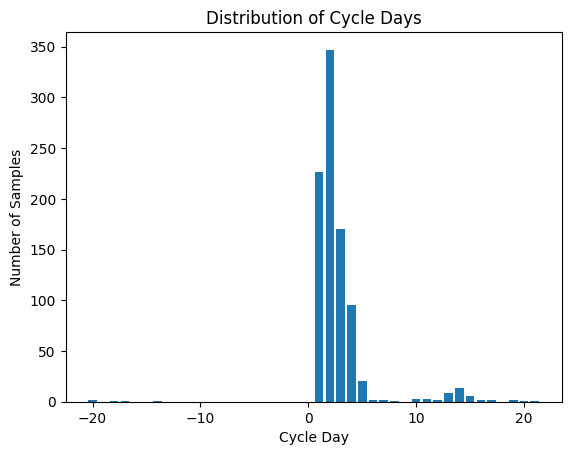

In [114]:
days_dist = dict()
for d in  metadata_df['Cycle.Day'].unique():
	days_dist[d] = (metadata_df['Cycle.Day'] == d).sum()

plt.bar(days_dist.keys(), days_dist.values())
plt.xlabel('Cycle Day')
plt.ylabel('Number of Samples')
plt.title('Distribution of Cycle Days')
plt.savefig('plots/cycle_days_dist.png')

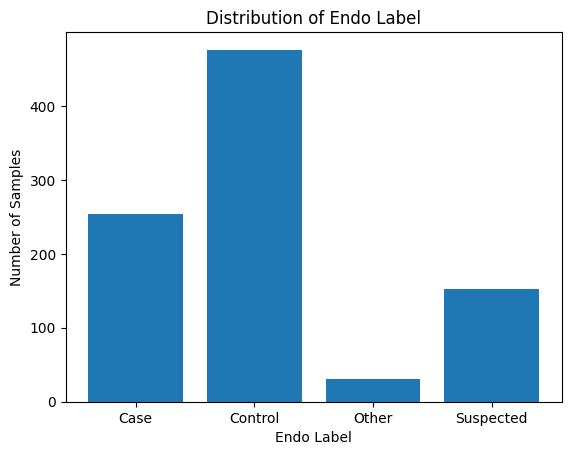

In [115]:
days_dist = dict()
for d in  metadata_df['Endo.Case.Control'].unique():
	days_dist[d] = (metadata_df['Endo.Case.Control'] == d).sum()

plt.bar(days_dist.keys(), days_dist.values())
plt.xlabel('Endo Label')
plt.ylabel('Number of Samples')
plt.title('Distribution of Endo Label')
plt.savefig('plots/endo_label_dist.png')

In [116]:
# drop rows with negative day values
metadata_df = metadata_df[metadata_df['Cycle.Day'] > 0]
# drop rows with day > 5
metadata_df = metadata_df[metadata_df['Cycle.Day'] <= 5]
# drop rows with other endo labels
metadata_df = metadata_df[metadata_df['Endo.Case.Control'] != 'Other']
# add column to encode endo label to 0 and 1
metadata_df['Endo.Case.Control'] = metadata_df['Endo.Case.Control'].map({'Case': 1, 'Control': 0, 'Suspected': 0.5})

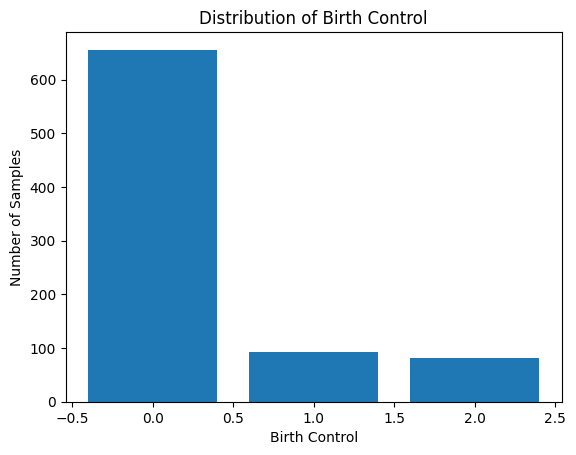

In [117]:
# plot dist of birth control
birth_map = {0: 0, 2: 1, 5: 1, 6: 1, 7: 1, 4:2, -3:2, 3:2, -1:2, -2:2, 1:2, 8:2}
days_dist = dict()
days_dist[0] = 0
days_dist[1] = 0
days_dist[2] = 0

for d in  metadata_df['Birth.Control'].unique():
	label = birth_map[d]
	days_dist[label] += (metadata_df['Birth.Control'] == d).sum()

plt.bar(days_dist.keys(), days_dist.values())
plt.xlabel('Birth Control')
plt.ylabel('Number of Samples')
plt.title('Distribution of Birth Control')
plt.savefig('plots/birth_control_dist.png')

In [118]:
# add column to encode Birth.Control
metadata_df['Birth.Control'] = metadata_df['Birth.Control'].map(birth_map)

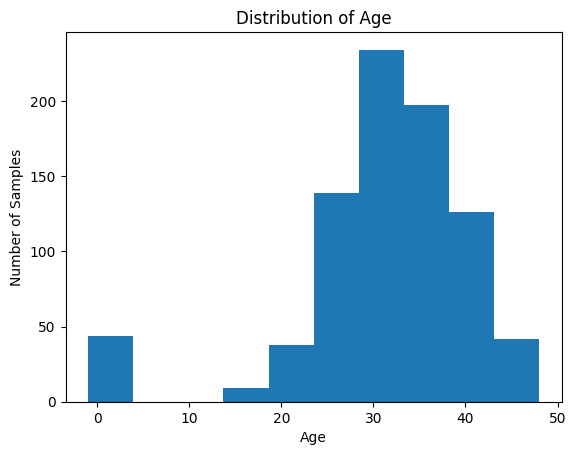

In [119]:
# plot dist of age
plt.hist(metadata_df['Age'])
plt.xlabel('Age')
plt.ylabel('Number of Samples')
plt.title('Distribution of Age')
plt.savefig('plots/age_dist.png')

In [120]:
# add column to bucket age into 6 groups
age_binned = []
for age in metadata_df['Age']:
	if age == -1:
		age_binned.append(-1)
	elif age < 33:
		age_binned.append(0)
	else:
		age_binned.append(1)

metadata_df['Age.Binned'] = age_binned

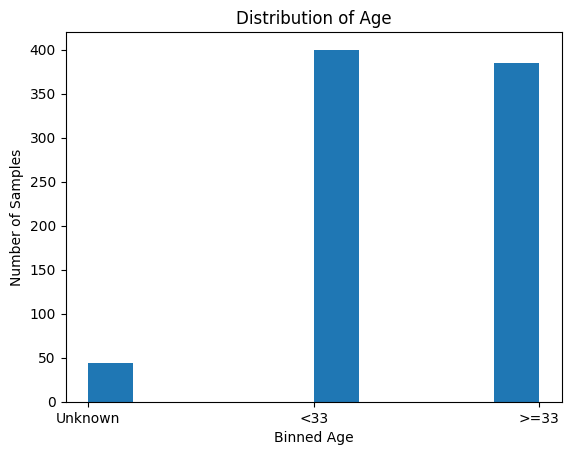

In [121]:
# replot dist of age
plt.hist(metadata_df['Age.Binned'])
plt.xticks([-1, 0, 1], ['Unknown', '<33', '>=33'])
plt.xlabel('Binned Age')
plt.ylabel('Number of Samples')
plt.title('Distribution of Age')
plt.savefig('plots/age_binned_dist.png')

In [122]:
metaData_col = ['ESG', 'Cycle.Day', 'Endo.Case.Control', 'Age.Binned', 'Cycle', 'Birth.Control']
metaData = metadata_df[metaData_col]
metaData.head()

,ESG,Cycle.Day,Endo.Case.Control,Age.Binned,Cycle,Birth.Control
Patient,,,,,,
E01-A0129,ESG3761,4,1.0,0,a,0
H01-A0206,ESG3096,2,0.0,0,b,0
H01-A0211,ESG3075,2,0.0,0,b,0
E01-A0014,ESG3704,1,1.0,1,c,0
H01-A0187,ESG2332,4,0.0,0,a,0


In [123]:
df = metaData.merge(Exp, right_index=True, left_on='ESG')
df.head()

,ESG,Cycle.Day,Endo.Case.Control,Age.Binned,Cycle,Birth.Control,aDC_HPCA_1,aDC_HPCA_2,aDC_HPCA_3,aDC_IRIS_1,...,Th2 cells_IRIS_3,Tregs_BLUEPRINT_1,Tregs_BLUEPRINT_2,Tregs_BLUEPRINT_3,Tregs_FANTOM_1,Tregs_FANTOM_2,Tregs_FANTOM_3,Tregs_HPCA_1,Tregs_HPCA_2,Tregs_HPCA_3
Patient,,,,,,,,,,,,,,,,,,,,,
E01-A0129,ESG3761,4,1.0,0,a,0,2.71865,2.8292,2.8292,1.9376,...,0.91635,1.8553,1.4509,2.3749,1.4509,2.3749,1.3016,0.01,0.01,0.01
H01-A0206,ESG3096,2,0.0,0,b,0,3.3236,3.81005,3.81005,2.9811,...,3.0052,3.3424,3.0319,3.9313,3.0319,3.9313,2.8903,2.5211,2.34405,2.4209
H01-A0211,ESG3075,2,0.0,0,b,0,0.7587,2.3428,2.3428,1.712,...,1.40895,2.61645,2.561,2.7156,2.561,2.7156,1.6034,0.6911,0.3249,0.6498
E01-A0014,ESG3704,1,1.0,1,c,0,3.34495,3.70365,3.70365,2.7333,...,2.13205,3.2727,3.522,3.522,3.522,3.522,0.8552,0.12975,0.005,0.01
H01-A0187,ESG2332,4,0.0,0,a,0,4.26185,4.4523,4.4523,4.0695,...,3.0184,4.303,4.3056,4.4881,4.3056,4.4881,3.6713,2.29095,1.0515,2.093


In [124]:
print("After removing duplicates, dataset size:", df.shape)

After removing duplicates, dataset size: (829, 495)


In [125]:
# save df to file
df.to_csv(f'{save_dir}/exp_metadata_cleaned_js_{DATA}.csv', sep='\t')

In [126]:
# split data by age
df_age_le = df[df['Age.Binned'] == 0]
df_age_le.to_csv(f'{save_dir}/exp_metadata_cleaned_js_agele33_{DATA}.csv', sep='\t')
print("Age < 33, dataset size:", df_age_le.shape)

Age < 33, dataset size: (400, 495)


In [127]:
# split data by age
df_age_ge = df[df['Age.Binned'] == 1]
df_age_ge.to_csv(f'data/exp_metadata_cleaned_js_agege33_{DATA}.csv', sep='\t')
print("Age >= 33, dataset size:", df_age_ge.shape)

Age >= 33, dataset size: (385, 495)


In [128]:
# split data by endo label
df_case = df[df['Endo.Case.Control'] == 1]
df_case.to_csv(f'data/exp_metadata_cleaned_js_case_{DATA}.csv', sep='\t')

df_control = df[df['Endo.Case.Control'] == 0]
df_control.to_csv(f'data/exp_metadata_cleaned_js_control_{DATA}.csv', sep='\t')

df_suspect = df[df['Endo.Case.Control'] == 0.5]
df_suspect.to_csv(f'data/exp_metadata_cleaned_js_sus_{DATA}.csv', sep='\t')

print(df_case.head()['Endo.Case.Control'], df_control.head()['Endo.Case.Control'], df_suspect.head()['Endo.Case.Control'])

Patient
E01-A0129    1.0
E01-A0014    1.0
E01-A0143    1.0
E01-A0023    1.0
E01-A0078    1.0
Name: Endo.Case.Control, dtype: float64 Patient
H01-A0206    0.0
H01-A0211    0.0
H01-A0187    0.0
H01-A0182    0.0
E01-A0043    0.0
Name: Endo.Case.Control, dtype: float64 Patient
E01-A0109    0.5
E01-A0017    0.5
E01-A0071    0.5
E01-A0071    0.5
E01-A0116    0.5
Name: Endo.Case.Control, dtype: float64


In [129]:
# split data by birth control
df_bc_0 = df[df['Birth.Control'] == 0]
df_bc_0.to_csv(f'data/exp_metadata_cleaned_js_bc0_{DATA}.csv', sep='\t')

df_bc_1 = df[df['Birth.Control'] == 1]
df_bc_1.to_csv(f'data/exp_metadata_cleaned_js_bc1_{DATA}.csv', sep='\t')

df_bc_2 = df[df['Birth.Control'] == 2]
df_bc_2.to_csv(f'data/exp_metadata_cleaned_js_bc2_{DATA}.csv', sep='\t')

print(df_bc_0.head()['Birth.Control'], df_bc_1.head()['Birth.Control'], df_bc_2.head()['Birth.Control'])

Patient
E01-A0129    0
H01-A0206    0
H01-A0211    0
E01-A0014    0
H01-A0187    0
Name: Birth.Control, dtype: int64 Patient
H01-A0199    1
H01-A0199    1
E01-A0072    1
E01-A0111    1
E01-A0109    1
Name: Birth.Control, dtype: int64 Patient
H01-A0163    2
H01-A0163    2
H01-A0200    2
H01-A0200    2
E01-A0023    2
Name: Birth.Control, dtype: int64
